# Big Data Analysis of Intensive Care Unit Data Using PySpark and Pipeline

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.sql.types import ArrayType, StringType, BooleanType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
import utils

%load_ext autoreload
%autoreload 2

LABEL = 'LOS'

spark = SparkSession.builder \
    .appName("Intensive Care Unit Data Analysis") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.memory.fraction", "0.9") \
    .config("spark.memory.storageFraction", "0.5") \
    .getOrCreate()

# check spark configs to only errors:

spark.sparkContext.setLogLevel("ERROR")
spark.conf.set("spark.sql.shuffle.partitions", "500")
spark.conf.set("spark.sql.debug.maxToStringFields", "1000")

In [36]:
# Reading the datasets
df_admissions = spark.read.csv("datasets/ADMISSIONS.csv", header=True, inferSchema=True).drop("ROW_ID")
df_diagnoses = spark.read.csv("datasets/DIAGNOSES_ICD.csv", header=True, inferSchema=True).drop("ROW_ID")
df_icustays = spark.read.csv("datasets/ICUSTAYS.csv", header=True, inferSchema=True).drop("ROW_ID")
df_patients = spark.read.csv("datasets/PATIENTS.csv", header=True, inferSchema=True).drop("ROW_ID")

In [37]:
df = df_patients.join(df_admissions, df_patients["SUBJECT_ID"] == df_admissions["SUBJECT_ID"], how="left").drop(df_admissions["SUBJECT_ID"])
df = df.join(df_icustays, df["HADM_ID"] == df_icustays["HADM_ID"], how="left").drop(df_icustays["SUBJECT_ID"]).drop(df_icustays["HADM_ID"])
df = df.join(df_diagnoses, df["SUBJECT_ID"] == df_diagnoses["SUBJECT_ID"], how="left").drop(df_diagnoses["SUBJECT_ID"]).drop(df_diagnoses["HADM_ID"])

Check for missing values in the dataset so that we can handle them appropriately.

In [5]:
utils.print_missing_value_counts(df)

-RECORD 0-----------------------
 SUBJECT_ID           | 0       
 GENDER               | 0       
 DOB                  | 0       
 DOD                  | 697342  
 DOD_HOSP             | 892628  
 DOD_SSN              | 839693  
 EXPIRE_FLAG          | 0       
 HADM_ID              | 0       
 ADMITTIME            | 0       
 DISCHTIME            | 0       
 DEATHTIME            | 1359709 
 ADMISSION_TYPE       | 0       
 ADMISSION_LOCATION   | 0       
 DISCHARGE_LOCATION   | 0       
 INSURANCE            | 0       
 LANGUAGE             | 379832  
 RELIGION             | 3721    
 MARITAL_STATUS       | 78080   
 ETHNICITY            | 0       
 EDREGTIME            | 476403  
 EDOUTTIME            | 476403  
 DIAGNOSIS            | 747     
 HOSPITAL_EXPIRE_FLAG | 0       
 HAS_CHARTEVENTS_DATA | 0       
 ICUSTAY_ID           | 31975   
 DBSOURCE             | 31975   
 FIRST_CAREUNIT       | 31975   
 LAST_CAREUNIT        | 31975   
 FIRST_WARDID         | 31975   
 LAST_WARD

# Feature Engineering

Let's create a column called 'AGE'. We can calculate the age of the patient at the time of admission by subtracting the date of birth from the admission date.

In [38]:
# Transform the 'DOB' and 'ADMITTIME' columns to date format
df = df.withColumn('DOB', F.to_date('DOB'))
df = df.withColumn('ADMITTIME', F.to_date('ADMITTIME'))

# Create the 'AGE' column by calculating the difference in years between 'ADMITTIME' and 'DOB'
df = df.withColumn('AGE', F.expr("floor(months_between(ADMITTIME, DOB) / 12)"))

It only matters if the patient is dead or not, not the date of death, so we can drop the date of death columns. And we also drop other death-related columns. 

In [39]:
df=df.drop("DOB").drop("DOD").drop("DOD_SSN").drop("EXPIRE_FLAG").drop("DEATHTIME")
df = df.withColumn("DOD_HOSP", F.when(F.col("DOD_HOSP").isNull(), 0).otherwise(1))
df = df.withColumnRenamed("DOD_HOSP", "DIED")
df = df.withColumnRenamed("ICD9_CODE","DISEASES_CODE")

Here we will drop the columns that are not useful for the analysis.

In [40]:
columns_to_remove = [
    "ADMITTIME", "DISCHTIME", "EDREGTIME", "EDOUTTIME", "HOSPITAL_EXPIRE_FLAG",
    "INTIME", "OUTTIME","LANGUAGE","DISCHARGE_LOCATION",
    "ICUSTAY_ID", "SEQ_NUM","HAS_CHARTEVENTS_DATA","DBSOURCE"
]

df = df.drop(*columns_to_remove)

The ethnicity column has too many unique values. We can group them into a few categories.

In [41]:
df = df.withColumn("ETHNICITY",
    F.when(F.col("ETHNICITY").isin('AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'),
           'American Indian/Alaska Native')
    .when(F.col("ETHNICITY").isin('ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CAMBODIAN', 'ASIAN - CHINESE', 'ASIAN - FILIPINO', 'ASIAN - JAPANESE', 'ASIAN - KOREAN', 'ASIAN - OTHER', 'ASIAN - THAI', 'ASIAN - VIETNAMESE'),
          'Asian')
    .when(F.col("ETHNICITY").isin('BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'),
          'Black')
    .when(F.col("ETHNICITY").isin('HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN'),
          'Hispanic/Latino')
    .when(F.col("ETHNICITY").isin('MIDDLE EASTERN'),
          'Middle Eastern')
    .when(F.col("ETHNICITY").isin('NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'),
          'Pacific Islander')
    .when(F.col("ETHNICITY").isin('WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN', 'PORTUGUESE'),
          'White')
    .when(F.col("ETHNICITY").isin('CARIBBEAN ISLAND', 'SOUTH AMERICAN'),
          'Caribbean/South American')
    .when(F.col("ETHNICITY").isin('MULTI RACE ETHNICITY'),
          'Multi-Race')
    .when(F.col("ETHNICITY").isin('OTHER'),
          'Other')
    .otherwise('NO DATA REGISTERED')
)

Now we can aggregate the data by primary keys and collect the remaining columns into lists. 

In [42]:
primary_key_columns = ["SUBJECT_ID", "HADM_ID"]

remaining_columns = [col for col in df.columns if col not in primary_key_columns]

df = df.groupBy(primary_key_columns).agg(*(F.collect_list(col).alias(col) for col in remaining_columns))

Now we can transform the columns that contain lists of values. If all values in the list are the same, we can replace the list with a single value. If the list is empty, we can replace it with a default value.

In [43]:
replace_empty_list_udf = F.udf(utils.replace_empty_list, ArrayType(StringType()))
transform_list_udf = F.udf(utils.transform_list, ArrayType(StringType()))
handle_list_udf = F.udf(utils.handle_list, StringType())
empty_list_udf = F.udf(lambda col: col == [], BooleanType())

for column in df.columns:    
    if isinstance(df.schema[column].dataType, ArrayType):
        if df.filter(empty_list_udf(F.col(column))).count() > 0:
            df = df.withColumn(column, replace_empty_list_udf(F.col(column)))
            
        df = df.withColumn(column, transform_list_udf(F.col(column)))
        if len(set(df.select(column).first()[0])) == 1:
            df = df.withColumn(column, handle_list_udf(df[column]))

Checking for missing values again.

In [13]:
utils.print_missing_value_counts(df)

-RECORD 0-----------------
 SUBJECT_ID         | 0   
 HADM_ID            | 0   
 GENDER             | 0   
 DIED               | 0   
 ADMISSION_TYPE     | 0   
 ADMISSION_LOCATION | 0   
 INSURANCE          | 0   
 RELIGION           | 0   
 MARITAL_STATUS     | 0   
 ETHNICITY          | 0   
 DIAGNOSIS          | 0   
 FIRST_CAREUNIT     | 0   
 LAST_CAREUNIT      | 0   
 FIRST_WARDID       | 0   
 LAST_WARDID        | 0   
 LOS                | 0   
 DISEASES_CODE      | 0   
 AGE                | 0   



Now let's analyze the diseases column. We can explode the column and calculate the mean length of stay for each disease code. Then we can rank the diseases for each patient and keep the top-ranked one.

In [44]:
# Explode the DISEASES_CODE column
exploded_df = df.withColumn("DISEASES_CODE", F.explode(F.col("DISEASES_CODE")))

# Calculate mean LOS for each disease code
disease_mean_los = exploded_df.groupBy("DISEASES_CODE").agg(F.mean("LOS").alias("mean_LOS"))

# Join the mean LOS back to the exploded dataframe
joined_df = exploded_df.join(disease_mean_los, on="DISEASES_CODE", how="left")

# Define window specification
window_spec = Window.partitionBy("SUBJECT_ID", "HADM_ID").orderBy(F.col("mean_LOS").desc())

# Rank disease codes for each patient and filter to keep the top-ranked one
most_influential_disease_df = joined_df.withColumn("rank", F.row_number().over(window_spec)).filter(F.col("rank") == 1)

# Select the relevant columns
result_df = most_influential_disease_df.select("SUBJECT_ID", "HADM_ID", "DISEASES_CODE")

# Ensure DISEASES_CODE is a string in both DataFrames
df = df.withColumn("DISEASES_CODE", F.col("DISEASES_CODE").cast("string"))
result_df = result_df.withColumn("DISEASES_CODE", F.col("DISEASES_CODE").cast("string"))

# Drop the DISEASES_CODE column from df before joining
df = df.drop("DISEASES_CODE")

# Join df with result_df on SUBJECT_ID and HADM_ID
updated_df = df.join(result_df, on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Add the updated DISEASES_CODE column from result_df
df = updated_df.withColumn(
    "DISEASES_CODE",
    F.coalesce(result_df["DISEASES_CODE"], F.col("DISEASES_CODE"))
)

df = df.withColumnRenamed("DISEASES_CODE", "DISEASE_CODE")

In [ ]:
# Show the updated DataFrame
# df.show()

# Graphical Analysis

## Unique Value Count of marital status

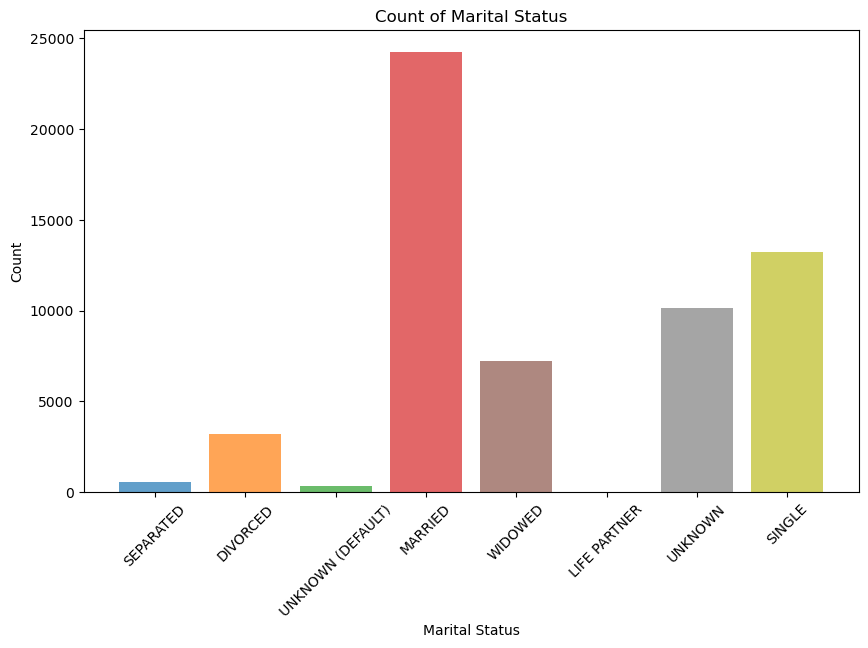

In [17]:
utils.plot_graph(df, 'MARITAL_STATUS', 'MARITAL_STATUS', F.count, 'Count of Marital Status', 'Marital Status', 'Count')

## Unique Value Count of Admission Types

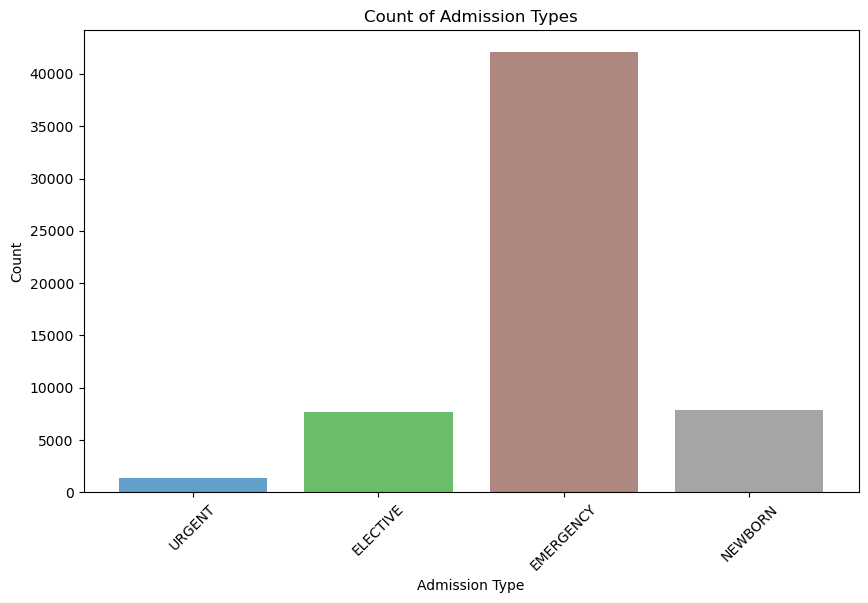

In [18]:
utils.plot_graph(df, 'ADMISSION_TYPE', 'ADMISSION_TYPE', F.count, 'Count of Admission Types', 'Admission Type', 'Count')

We can see in the visual representation that the majority of admission type is emergency, by a lot.

## Distribution of Length of Stay by Gender

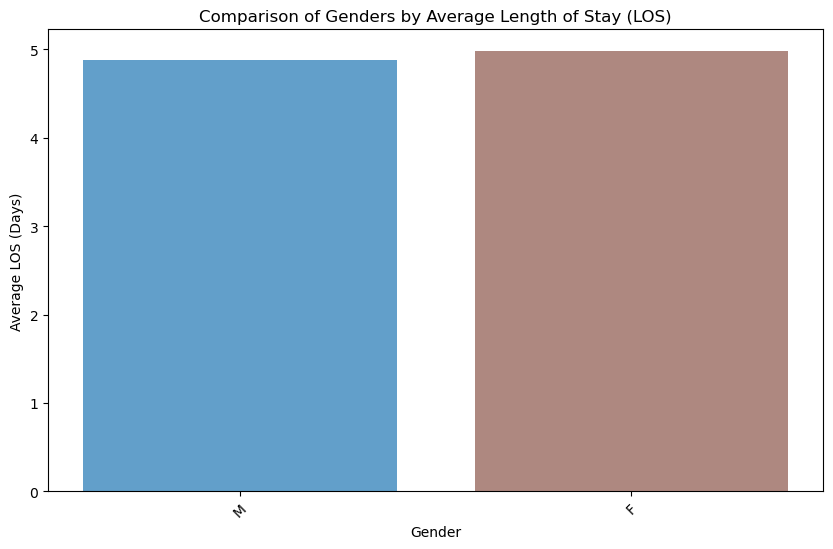

In [19]:
# Calculate average LOS per gender
average_los_per_gender = df.groupBy('GENDER')\
    .agg(F.avg('LOS').alias('Average LOS'))\
    .orderBy(F.col('Average LOS').desc())

# Call the plot_graph function
utils.plot_graph(
    average_los_per_gender,
    'GENDER',
    'Average LOS',
    F.first,
    'Comparison of Genders by Average Length of Stay (LOS)',
    'Gender',
    'Average LOS (Days)'
)

## Distribution of Length of Stay by Age

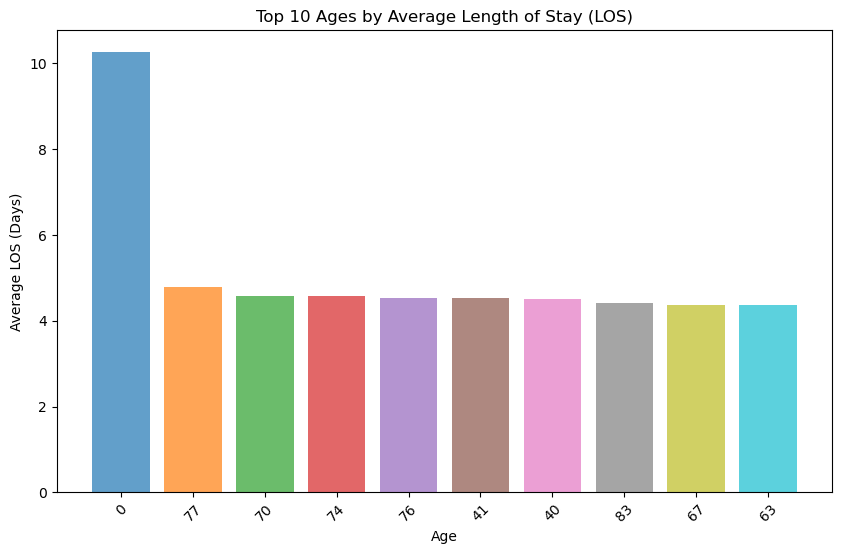

In [20]:
# Calculate average LOS per age
average_los_per_age = df.filter(df['AGE'] < 100).groupBy('AGE')\
    .agg(F.avg('LOS').alias('Average LOS'))\
    .orderBy(F.col('Average LOS').desc())\
    .limit(10)

# Call the plot_graph function
utils.plot_graph(
    average_los_per_age,
    'AGE',
    'Average LOS',
    F.first,
    'Top 10 Ages by Average Length of Stay (LOS)',
    'Age',
    'Average LOS (Days)'
)

As we can see, newborns are by far the ones that stay more time at the hospital, having an average of more than 10 days. Older people (age 77) are the ones that follow. However, we can also see ages such as 40 and 41 in the top 10.

## Distribution of Length of Stay by Insurance

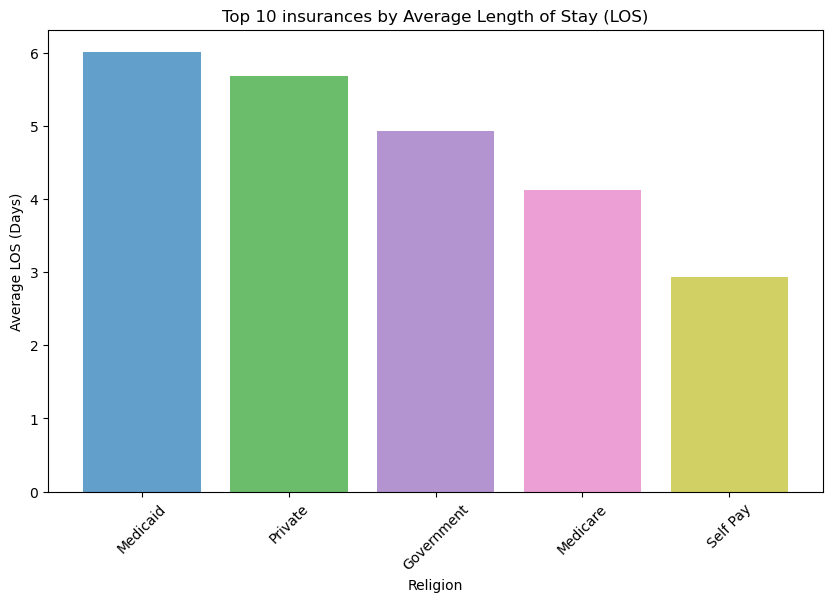

In [45]:
# Calculate average LOS per religion
average_los_per_religion = df.groupBy('INSURANCE')\
    .agg(F.avg('LOS').alias('Average LOS'))\
    .orderBy(F.col('Average LOS').desc())\
    .limit(10)

# Call the plot_graph function
utils.plot_graph(
    average_los_per_religion,
    'INSURANCE',
    'Average LOS',
    F.first,
    'Top 10 insurances by Average Length of Stay (LOS)',
    'Religion',
    'Average LOS (Days)'
)

## Distribution of Length of Stay by Religion

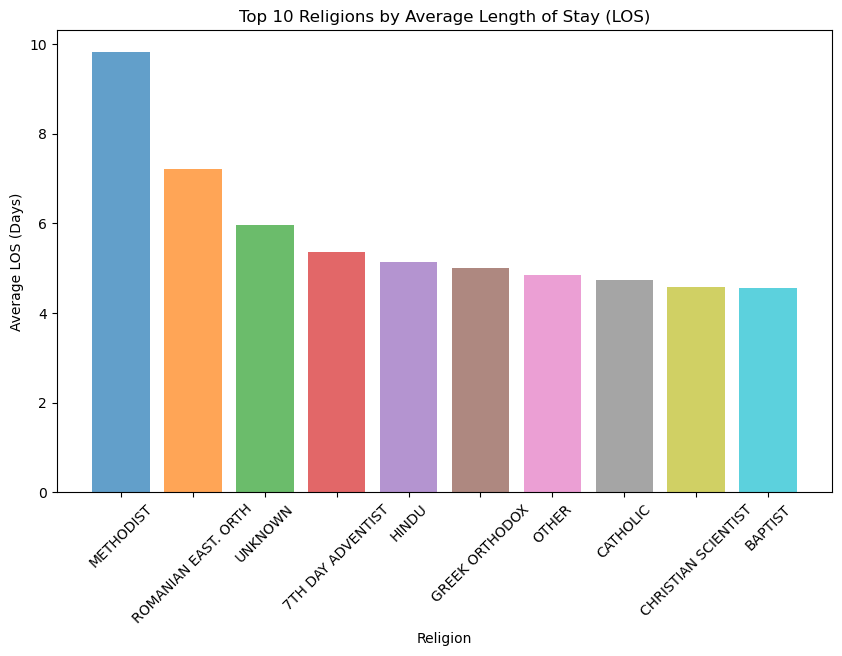

In [21]:
# Filter out rows where RELIGION is 'UNOBTAINABLE'
filtered_df = df.filter(df['RELIGION'] != 'UNOBTAINABLE')

# Calculate average LOS per religion
average_los_per_religion = filtered_df.groupBy('RELIGION')\
    .agg(F.avg('LOS').alias('Average LOS'))\
    .orderBy(F.col('Average LOS').desc())\
    .limit(10)

# Call the plot_graph function
utils.plot_graph(
    average_los_per_religion,
    'RELIGION',
    'Average LOS',
    F.first,
    'Top 10 Religions by Average Length of Stay (LOS)',
    'Religion',
    'Average LOS (Days)'
)

For this visualization, since there are some religions that have certain rules such as not being able to receive blood transfers, it is important to check if the religion is indeed related to the length of the stay. From the visualization, we were not able to find any connection between religion and the stay.

## Distribution of Length of Stay by Ethnicity

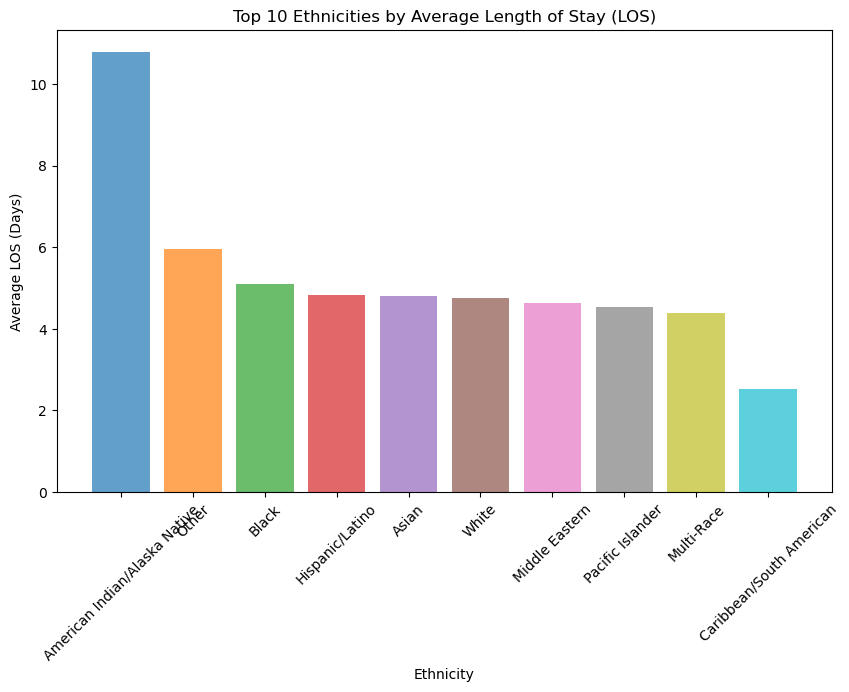

In [22]:
# Filter out rows where ETHNICITY is 'NO DATA REGISTERED'
filtered_df = df.filter(df['ETHNICITY'] != 'NO DATA REGISTERED')

# Calculate average LOS per ethnicity
average_los_per_ethnicity = filtered_df.groupBy('ETHNICITY')\
    .agg(F.avg('LOS').alias('Average LOS'))\
    .orderBy(F.col('Average LOS').desc())\
    .limit(10)

# Call the plot_graph function
utils.plot_graph(
    average_los_per_ethnicity,
    'ETHNICITY',
    'Average LOS',
    F.first,
    'Top 10 Ethnicities by Average Length of Stay (LOS)',
    'Ethnicity',
    'Average LOS (Days)'
)

### Disparities in Hospital Care and Length of Stay Among Ethnicities

Healthcare systems across the globe strive to provide equitable care to all individuals, but disparities persist, particularly in the context of hospital care and the length of stay (LOS). Research indicates that ethnic minorities often experience longer hospital stays and face unique challenges in the healthcare environment.

American Indian/Alaska Native populations have historically faced barriers to healthcare access, which can lead to delayed hospital visits and consequently, longer LOS due to more advanced stages of illness upon admission.

Black patients often encounter systemic biases that affect their hospital care. Studies have shown that Black patients may have longer LOS compared to their White counterparts, even when factors like age, sex, chronic comorbidity, and acute disease severity are accounted for.

White patients, often used as a reference group in studies, tend to have shorter LOS than most minority groups. This could be attributed to a variety of factors, including socioeconomic status and access to resources.

Asian patients’ experiences can vary widely due to the diversity within this group. However, some studies suggest that Asian patients may have a LOS similar to or slightly longer than White patients.

From this information, we were able to exactly check those conclusions. American Indian/Alaska Native are the ones that struggle the most, staying 50% more days in the hospital than most races.

# Pre processing

Let's convert the categorical columns to numerical columns. And let's get the categorical and numerical columns names.

In [23]:
all_columns = df.columns
feature_columns = [col for col in all_columns if col not in ['SUBJECT_ID', 'HADM_ID', LABEL]]

numerical_features = ['FIRST_WARDID', 'LAST_WARDID', 'AGE']

categorical_features = [col for col in feature_columns if col not in numerical_features and col not in ['SUBJECT_ID', 'HADM_ID', LABEL]]

# Cast string numerical features to float
df = df.withColumn("AGE", F.col("AGE").cast("float"))
df = df.withColumn("FIRST_WARDID", F.col("FIRST_WARDID").cast("float"))
df = df.withColumn("LAST_WARDID", F.col("LAST_WARDID").cast("float"))
df = df.withColumn("LOS", F.col("LOS").cast("float"))

print(f"Numerical Features: {numerical_features}\n")
print(f"Categorical Features: {categorical_features}\n")

Numerical Features: ['FIRST_WARDID', 'LAST_WARDID', 'AGE']

Categorical Features: ['GENDER', 'DIED', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'DISEASE_CODE']



In [24]:
# Stages in the pipeline
stages = []

# Indexing and encoding categorical features
for categoricalCol in categorical_features:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "ClassVec"])
    stages += [stringIndexer, encoder]

# Assemble all the features along with the encoded categorical features
assemblerInputs = [c + "ClassVec" for c in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="keep")
stages += [assembler]

# Pipeline: This will ensure all stages are applied in sequence
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df_transformed = pipelineModel.transform(df)

Here we are making sure that there isn't simultaneously a patient in the test set and train set.

In [25]:
subject_ids = [row['SUBJECT_ID'] for row in df_transformed.select("SUBJECT_ID").distinct().collect()]
split_index = int(len(subject_ids) * 0.7) # 70% train, 30% test

train_ids = set(subject_ids[:split_index])
test_ids = set(subject_ids[split_index:])

# Directly filter the DataFrame using the list
train_df = df_transformed.filter(F.col("SUBJECT_ID").isin(train_ids))
test_df = df_transformed.filter(F.col("SUBJECT_ID").isin(test_ids))

# Ensure that both train and test data have non-null labels and drop the SUBJECT_ID and HADM_ID columns because they are not needed anymore
train_df = train_df.filter(train_df[LABEL].isNotNull()).drop("SUBJECT_ID").drop("HADM_ID")
test_df = test_df.filter(test_df[LABEL].isNotNull()).drop("SUBJECT_ID").drop("HADM_ID")

# Prediction

## Linear Regression

Linear Regression fits a linear equation to the data to predict LOS based on factors like age, medical history, and diagnosis. It's simple, interpretable, and effective for linear relationships, making it easy to understand how each factor influences LOS.

In [31]:
tuned_param = {
    'maxIter': 10,
    'regParam': 0.3,
    'elasticNetParam': 0.8
}

# Define and fit the Linear Regression model on the training set
lr = LinearRegression(featuresCol='features', labelCol=LABEL, **tuned_param)
lr_model = lr.fit(train_df)
pred_df = lr_model.transform(test_df)

In [32]:
utils.print_metrics(RegressionEvaluator(labelCol="LOS", predictionCol="prediction"), pred_df)

Mean of the difference between predicted and actual 'LOS': 0.00715
R2 score (proportion of variance predictable): 0.45
Root Mean Squared Error (average magnitude of errors): 7.41
Mean Squared Error (average of the squares of errors): 54.95




## Random Forest Regression

Random Forest Regression uses multiple decision trees to capture complex, non-linear relationships between variables. It is robust against overfitting and handles large, diverse datasets well, including those with missing data.

In [33]:
tuned_param = {
    'maxDepth': 5,
    'maxBins': 32,
    'minInstancesPerNode': 1,
    'minInfoGain': 0.0,
    'maxMemoryInMB': 256,
    'cacheNodeIds': False,
    'checkpointInterval': 10,
    'impurity': 'variance',
    'featureSubsetStrategy': 'auto',
    'subsamplingRate': 1.0,
    'seed': None,
    'numTrees': 20
}

# Define and fit the Random Forest model on the training set
rf = RandomForestRegressor(featuresCol='features', labelCol=LABEL, **tuned_param)
rf_model = rf.fit(train_df)
pred_df = rf_model.transform(test_df)

In [34]:
utils.print_metrics(RegressionEvaluator(labelCol="LOS", predictionCol="prediction"), pred_df)

Mean of the difference between predicted and actual 'LOS': 0.0049
R2 score (proportion of variance predictable): 0.37
Root Mean Squared Error (average magnitude of errors): 7.91
Mean Squared Error (average of the squares of errors): 62.61



# Conclusion

We successfully analyzed the MIMIC-III dataset and built two regression models to predict the length of stay (LOS) for patients. Our Linear Regression model achieved an RMSE of 7.41, while the Random Forest Regression model had an RMSE of 7.91. Despite the slightly higher RMSE, the Random Forest model performed marginally better in handling complex, non-linear data, suggesting it may be more suitable for predicting LOS in MIMIC-III patients.

We also performed feature engineering, data preprocessing, and model training using PySpark, a robust distributed computing framework. Leveraging PySpark allowed us to efficiently process and analyze large-scale healthcare data, enhancing our model's performance and scalability.